In [1]:
from glob import glob
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
log_path=sorted(glob('./res_log/*'))

In [3]:
# for log_file in log_path:
#     with open(log_file) as f:
#         if 'Early' in f.read():
#             print(log_file)

In [4]:
rx_dict = {
    'error_down': re.compile(r'down sim 500: (?P<error_down>.*)\n'),
    'mean_dist': re.compile(r'both up and down: (?P<mean_dist>.*)\n'),
    'error_up': re.compile(r'up sim 500: (?P<error_up>.*)\n'),
    'error_stay': re.compile(r'stay sim 500: (?P<error_stay>.*)\n'),
    'total_params':re.compile(r'Total params: (?P<total_params>.*)\n'),
}

In [5]:
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None

In [6]:
def parse_file(filepath):

    # open the file and read through it line by line
    with open(filepath, 'r') as file_object:
        line = file_object.readline()
        while line:
            # at each line check for a match with a regex
            key, match = _parse_line(line)

            if key == 'error_down':
                error_down = match.group('error_down')
                error_down=int(error_down)
                
            if key == 'mean_dist':
                mean_dist = match.group('mean_dist')
                mean_dist=float(mean_dist)
                
            if key == 'error_up':
                error_up = match.group('error_up')
                error_up=int(error_up)
                
            if key == 'error_stay':
                error_stay = match.group('error_stay')
                error_stay=int(error_stay)
                
            if key == 'total_params':
                total_params = match.group('total_params')
                
            line = file_object.readline()
            

    return [error_down,error_up,error_stay,mean_dist,total_params]

In [7]:
res_list=[]
for path in log_path:
    _log=parse_file(path)
    if len(os.path.basename(path).split("_"))==7:
        int_path=[''.join(os.path.basename(path).split("_")[:6])]
    else:
        int_path=[''.join(os.path.splitext(os.path.basename(path))[0].split("_"))]
    int_path=int(int_path[0])
    _log.append(int_path)
    
    res_list.append(_log)
    

In [8]:
res_arr=np.array(res_list)

In [9]:
res_df = pd.DataFrame(res_arr, columns=['error_down', 'error_up', 'error_stay', 'mean_dist', 'total_params'
                                       , 'file_name'])

In [10]:
res_df

,error_down,error_up,error_stay,mean_dist,total_params,file_name
0,0,0,0,137.2223520649639,313,101010111
1,0,0,0,134.14566820393335,313,101010111
2,0,0,0,135.36104830422676,313,101010111
3,0,0,0,134.84112066232808,313,101010111
4,0,0,1,132.0152592228053,643,101010222
...,...,...,...,...,...,...
519,0,0,0,133.2426979011194,"13,683",808080111
520,0,0,0,130.90186270358987,"33,123",808080222
521,0,0,0,132.44833418215222,"33,123",808080222
522,2,0,2,130.8339218679489,"33,123",808080222


In [11]:
res_df.to_csv("res_df.csv", mode='w')

In [12]:
for i in range(len(res_arr)):
    res_arr[i,4]=int(res_arr[i,4].replace(',',''))

In [13]:
std_temp=res_arr[:,:4].astype(np.float32)
std_arr=np.zeros((int(len(res_arr)/4),3))
for i in range(0,int(len(res_arr)/4)):
    std_arr[i,0]=np.mean(std_temp[4*i:4*(i+1),-1])
    std_arr[i,1]=np.std(std_temp[4*i:4*(i+1),-1])
    std_arr[i,2]=res_arr[4*i,4]

In [14]:
hyper_params=res_arr[::4,-1]
std_arr=np.hstack([std_arr,hyper_params.reshape(131,-1)])

In [15]:
std_df=pd.DataFrame(std_arr, columns=['mean_mean_dist', 'std_mean_dist', 'num_params','hyper_params'])

In [16]:
std_df

,mean_mean_dist,std_mean_dist,num_params,hyper_params
0,135.39254760742188,1.14104425907135,313.0,101010111
1,131.95924377441406,0.33274754881858826,643.0,101010222
2,133.3686981201172,0.5499991178512573,1023.0,202020111
3,132.17578125,0.5294870138168335,2283.0,202020222
4,133.71481323242188,0.8390873670578003,1503.0,202040111
...,...,...,...,...
126,131.50448608398438,0.3806193172931671,24923.0,808040222
127,133.78826904296875,0.3488175868988037,12003.0,808060111
128,131.00352478027344,0.5322102904319763,28623.0,808060222
129,133.6107177734375,0.33318275213241577,13683.0,808080111


In [17]:
std_df.to_csv("std_df_fix.csv", mode='w')

In [18]:
compare_table=std_df.values
compare_table[:,:-1]=compare_table[:,:-1].astype(np.float32)/np.max(compare_table[:,:-1],axis=0).astype(np.float32)

In [19]:
compare_df=pd.DataFrame(compare_table, columns=['mean_mean_dist', 'std_mean_dist', 'num_params','hyper_params'])
compare_df

,mean_mean_dist,std_mean_dist,num_params,hyper_params
0,0.986999,0.959636,0.0316066,101010111
1,0.96197,0.279846,0.0649298,101010222
2,0.972245,0.462558,0.103302,202020111
3,0.963549,0.445307,0.230536,202020222
4,0.974768,0.705685,0.151772,202040111
...,...,...,...,...
126,0.958655,0.320107,2.51671,808040222
127,0.975304,0.293361,1.21206,808060111
128,0.955003,0.447597,2.89034,808060222
129,0.974009,0.280212,1.3817,808080111


In [20]:
compare_df.to_csv("compare_df_fix.csv", mode='w')

In [21]:
compare_sum=compare_table[:,0]*0.8+1/compare_table[:,1]*0.1+compare_table[:,-2]*0.1

In [22]:
compare_sum_df=pd.DataFrame(np.array([compare_sum,hyper_params]).T, columns=['compare_sum', 'hyper_params'])
compare_sum_df

,compare_sum,hyper_params
0,0.896966,101010111
1,1.13341,101010222
2,1.00432,202020111
3,1.01846,202020222
4,0.936698,202040111
...,...,...
126,1.33099,808040222
127,1.24233,808060111
128,1.27645,808060222
129,1.27425,808080111


In [23]:
compare_sum_df.to_csv("compare_sum_df_fix.csv", mode='w')

In [24]:
np.argmax(compare_sum)

39

In [25]:
compare_sum[39]

1.692866095090761

In [26]:
std_df.loc[39]

mean_mean_dist     0.961768
std_mean_dist      0.118989
num_params         0.830354
hyper_params      402060222
Name: 39, dtype: object

In [27]:
res_df.loc[39*4:40*4-1]

,error_down,error_up,error_stay,mean_dist,total_params,file_name
156,1,0,0,132.10363601408056,"8,223",402060222
157,0,0,0,132.03753583409767,"8,223",402060222
158,0,0,0,131.8071885911475,"8,223",402060222
159,0,0,1,131.77742484187962,"8,223",402060222


In [28]:
num_datas=np.array([300,600,1500,3000,6000,15000,30000,60000,150000,300000])
test_accs=np.array([70.73,69.83,90.79,93.47,98.36,98.29,98.26,98.38,97.30,98.53])
train_accs=np.array([75.67,79.50,96.87,97.47,99.07,99.31,99.44,99.49,99.48,99.62])

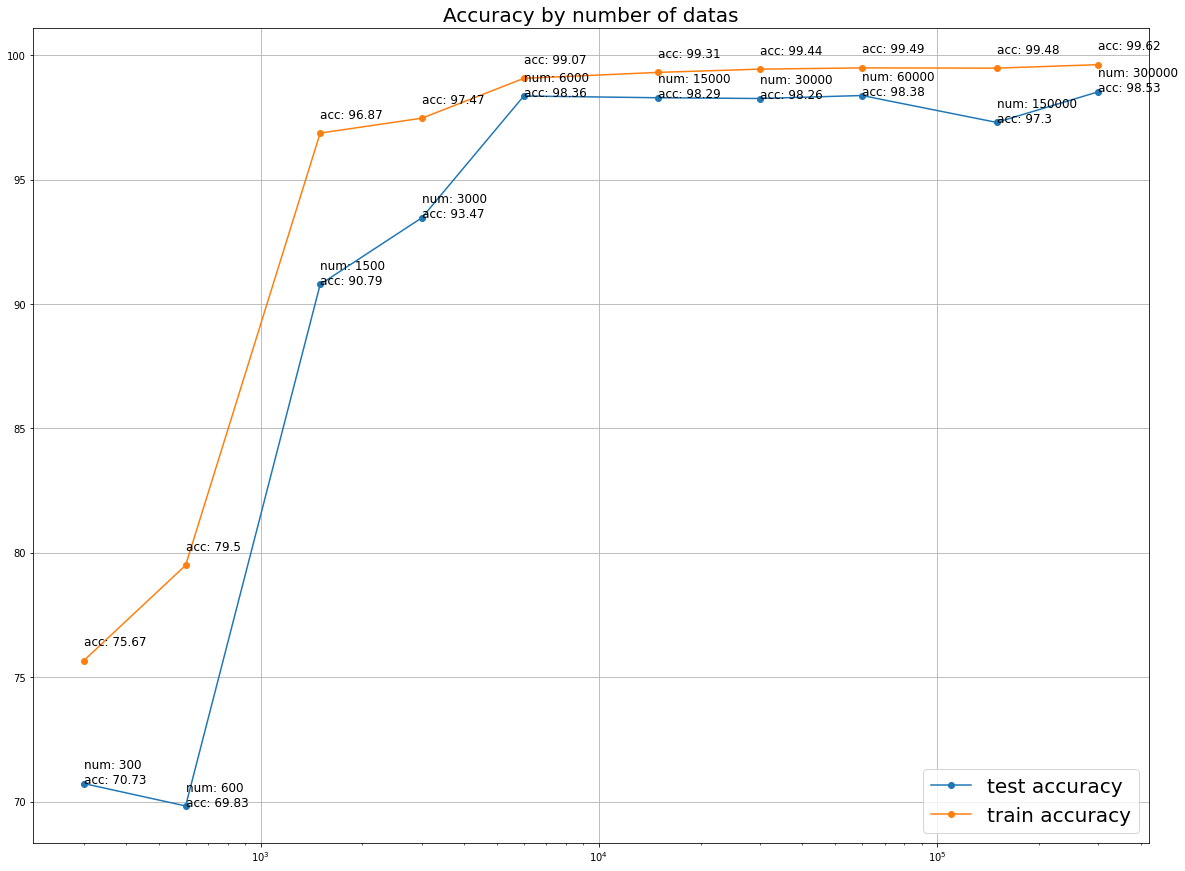

In [50]:
plt.figure(figsize=(20,15))
plt.xscale("log")
plt.grid()
plt.plot(num_datas, test_accs, marker='o',label='test accuracy')
plt.plot(num_datas, train_accs, marker='o',label='train accuracy')
plt.title("Accuracy by number of datas",fontsize=20)
for x,y in zip(num_datas, test_accs): 
    plt.text(x, y, "num: {}\nacc: {}".format(x, y), fontsize=12)
for x,y in zip(num_datas, train_accs): 
    plt.text(x, y, "acc: {}\n".format(y), fontsize=12)
plt.legend(loc='lower right',fontsize=20)
plt.show()